In [2]:
# Importing dependencies (for now)

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Explore the data

In [4]:
data = pd.read_csv('./data/data.csv')
data.head(5)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
data = data.drop('Unnamed: 0', axis = 1)

In [6]:
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [7]:
data = data.dropna()

In [8]:
classes = data['status'].unique()
classes

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [9]:
filtered_classes = {}
for cls in classes:
    filtered_classes[cls] = len(data[data['status'] == cls])

In [10]:
filtered_classes

{'Anxiety': 3841,
 'Normal': 16343,
 'Depression': 15404,
 'Suicidal': 10652,
 'Stress': 2587,
 'Bipolar': 2777,
 'Personality disorder': 1077}

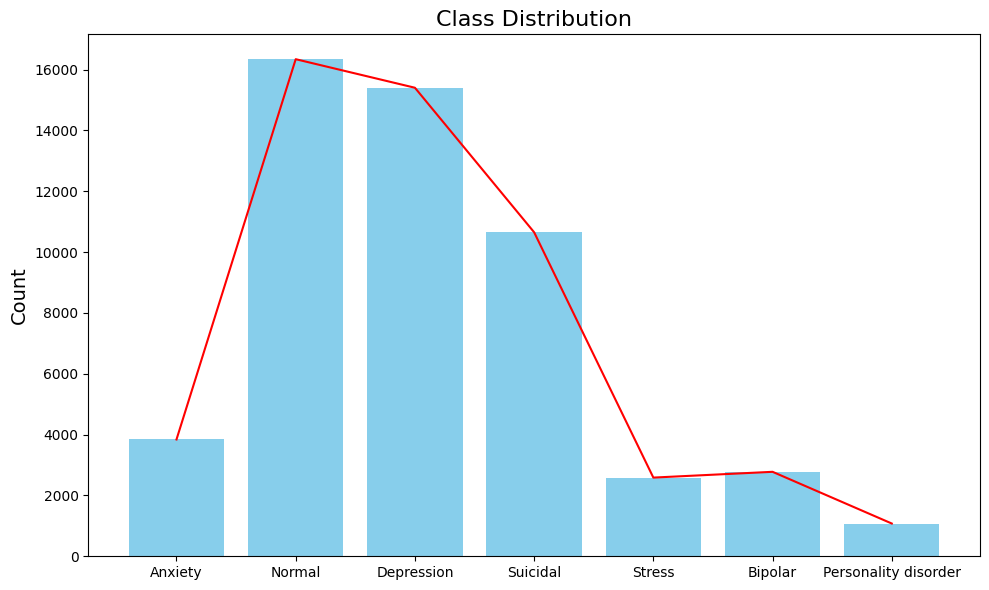

In [11]:
counts = list(filtered_classes.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.plot(classes, counts, color = 'red')
plt.title('Class Distribution', fontsize=16)

plt.ylabel('Count', fontsize=14)


plt.tight_layout()
plt.show()

## Split the data

In [12]:
data = data.sample(frac = 1)
X = data['statement']
y = data['status']

In [13]:
y = np.expand_dims(y, axis = 1)


In [14]:
len(X)

52681

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_one_hot_encoded = encoder.fit_transform(y)
classes = encoder.categories_[0]



In [16]:
classes

array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

In [17]:
y_one_hot_encoded.shape

(52681, 7)

In [18]:
y[0]

array(['Bipolar'], dtype=object)

In [19]:
y_one_hot_encoded[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
longest_string = X.str.len().idxmax()
longest_ticket_description = X.loc[longest_string]
longest_string_len = len(longest_ticket_description)
longest_string_len, longest_ticket_description

(32759,
 'I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I 

In [21]:
from utils import train_tokenizer
X_samples = X.tolist()

MAX_TOKENS = 10000
OUTPUT_SEQ_LENGTH = 1000

vectorizer = train_tokenizer(X_samples, MAX_TOKENS, OUTPUT_SEQ_LENGTH)

In [22]:
from utils import stack_samples
X_samples_final = stack_samples(X_samples, vectorizer)

In [23]:
vocab_size = vectorizer.vocabulary_size()
vocab_size

10000

In [24]:
X_samples_final.shape, y_one_hot_encoded.shape

((52681, 1000), (52681, 7))

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_samples_final, y_one_hot_encoded, train_size = 0.95)

## Test Model

In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(OUTPUT_SEQ_LENGTH,)),

    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256),

    tf.keras.layers.Conv1D(64, 5, 1, padding = 'valid', activation = 'relu'),
    tf.keras.layers.GlobalMaxPooling1D(),


    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    


    tf.keras.layers.Dense(len(classes), activation='softmax')
])

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [69]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model.h5', save_best_only=True)
def scheduler(epoch, lr):
    return 0.95 ** epoch * lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[model_checkpoint, early_stopping])

Epoch 1/30
782/782 [==============================] - 12s 12ms/step - loss: 1.0099 - accuracy: 0.6287 - val_loss: 0.6170 - val_accuracy: 0.7712
Epoch 2/30
782/782 [==============================] - 9s 11ms/step - loss: 0.6030 - accuracy: 0.7654 - val_loss: 0.5462 - val_accuracy: 0.7852
Epoch 3/30
782/782 [==============================] - 9s 11ms/step - loss: 0.4578 - accuracy: 0.8239 - val_loss: 0.5893 - val_accuracy: 0.7913
Epoch 4/30
782/782 [==============================] - 9s 11ms/step - loss: 0.3535 - accuracy: 0.8670 - val_loss: 0.5977 - val_accuracy: 0.7954
Epoch 5/30
782/782 [==============================] - 34s 43ms/step - loss: 0.2711 - accuracy: 0.9012 - val_loss: 0.6522 - val_accuracy: 0.7920


In [65]:
text = ["Sometimes, my heart races for no reason, and I can’t catch my breath. It’s terrifying and makes me feel out of control. I hate people and people hate me."]
prediction = model.predict(stack_samples(text, vectorizer))
classes[np.argmax(prediction)]

1/1 [==============================] - 0s 67ms/step


'Anxiety'

In [70]:
X_test

array([[   2,   15,  451, ...,    0,    0,    0],
       [ 111,   14,   53, ...,    0,    0,    0],
       [1654,  467,  358, ...,    0,    0,    0],
       ...,
       [ 110,  672,   38, ...,    0,    0,    0],
       [   1, 1601,   12, ...,    0,    0,    0],
       [   2,   25,  661, ...,    0,    0,    0]], dtype=int64)

In [71]:
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [76]:
classes

array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

In [79]:
np.savetxt('./data/classes.txt', classes, fmt='%s')

In [82]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorizer)

filepath = "./data/vectorizer"
model.save(filepath, save_format="tf")



INFO:tensorflow:Assets written to: ./data/vectorizer\assets
